In [1]:
import numpy as np
from matplotlib import pyplot as plt

from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import LocalPseudo, Functional, TotalFunctional, ExternalPotential
from dftpy.formats import io
from dftpy.math_utils import ecut2nr
from dftpy.time_data import TimeData
from dftpy.optimization import Optimization
from dftpy.mpi import sprint
from dftpy.interface import GetForces
from qepy.calculator import QEpyCalculator 
from qepy.io import QEInput
from qepy.driver import Driver

from ase.build import bulk
from ase.io import read
from ase.lattice.spacegroup import Spacegroup
from ase.lattice.spacegroup import crystal

import pickle

/home/vr371/.local/lib/python3.8/site-packages/ase/lattice/spacegroup.py:5: UserWarning: Moved to ase.spacegroup
  warnings.warn('Moved to ase.spacegroup')


#### Porpose of this code
Evaluate the energy of the system using OFDFT with the $\rho_{0}$'s found in the code named rho0_dT.
In this code we won't use the KS electron density, we will perform a fully OF calculation with the corrected Wang-Teter KEDF to obtain the equation of states graph.

In [5]:
path_pp='/home/vr371/PP/ofpp/EAC/upf/blps/'
file1='si.lda.upf'
PP_list = {'Si': path_pp+file1}

In [7]:
rho00 = np.load('/home/vr371/cWT-KEDF/Phases/DATA/Si_bcc/DATA2/rho0.npy')
KS_TE = []
for i in np.arange(0,30,1):
    with open('/home/vr371/cWT-KEDF/Phases/DATA/Si_bcc/DATA2/Si'+str(i)+'.out') as D:
        k = [match for match in D if "Total energy" in match]
    KS_te = str(k).split()[6]
    KS_TE.append(float(KS_te)) 

In [9]:
l = np.linspace(0.8, 1.4, 30)
rho0 = np.asarray(rho00)
XC = Functional(type='XC',name='LDA')
HARTREE = Functional(type='HARTREE')

ENERGY = []
VOLUME = []
Forces = []
for n in np.arange(0, 30, 1):
        i = int(n)
        
        KE = Functional(type='KEDF',name='WT', rho0=rho0[i])
        ions = Ions.from_ase(bulk('Si', 'bcc', a= 3.09, cubic=True))
        cell = ions.get_cell()
        ions.set_cell(cell * l[i], scale_atoms=True)
        ions.set_charges(4)

        nr = ecut2nr(ecut=25, lattice=ions.cell)
        grid = DirectGrid(lattice=ions.cell, nr=nr)
        rho_ini = DirectField(grid=grid)
        rho_ini[:] = ions.get_ncharges()/ions.cell.volume
        PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list, rcut=10)
        evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
        
        optimization_options = {'econv' : 1e-5*ions.nat}
        opt = Optimization(EnergyEvaluator=evaluator, optimization_options = optimization_options, 
                           optimization_method = 'TN')
        rho = opt.optimize_rho(guess_rho=rho_ini)
        forces = GetForces(ions, rho, evaluator)
        energy = evaluator.Energy(rho=rho, ions=ions)
        vol=ions.get_volume()

        ENERGY.append(energy)
        VOLUME.append(vol)
        Forces.append(forces)

setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       5.121982952391E+00      5.121983E+00    2.529854E+00    1       1       5.434513E-03    
1       4.670227091437E+00      -4.517559E-01   1.177824E-01    3       1       1.825976E-02    
2       4.657286760293E+00      -1.294033E-02   2.874532E-03    5       1       3.042388E-02    
3       4.657145540485E+00      -1.412198E-04   1.160652E-04    3       1       3.897858E-02    
4       4.657132887006E+00      -1.265348E-05   5.688647E-06    5       1       5.094004E-02    
5       4.657132349374E+00      -5.376321E-07   3.113244E-07    4       1       6.110311E-02    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.8183615309036917
Chemical potential (eV)  : 22.268749400072675
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP            

4       2.290476354563E+00      -7.514378E-05   4.071206E-05    6       1       6.648326E-02    
5       2.290473910370E+00      -2.444192E-06   3.451194E-06    3       1       7.634234E-02    
6       2.290473564450E+00      -3.459204E-07   2.085310E-07    5       1       8.989358E-02    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.4301623152047616
Chemical potential (eV)  : 11.705311695274721
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       2.397220644184E+00      2.397221E+00    1.329625E+00    1       1       4.480362E-03    
1       2.085880810041E+00      -3.113398E-01   9.925410E-02    5       1       1.966453E-02    
2       2.072406907980E+00      -1.347390E-02   9.281956E-03    6       1       3.546381E-02    
3       2.071848540839E+00      -5.583671E-04   8.267796E-04    3       1       4.507136E-02    
4       2.071740574766E+00  

setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       1.212375318915E+00      1.212375E+00    1.088331E+00    1       1       5.709171E-03    
1       6.770652270284E-01      -5.353101E-01   1.092429E-01    14      2       5.502796E-02    
2       6.677500360694E-01      -9.315191E-03   1.065409E-02    5       1       7.378745E-02    
3       6.662332317874E-01      -1.516804E-03   1.006103E-03    7       1       9.823775E-02    
4       6.661618022827E-01      -7.142950E-05   9.387917E-05    4       1       1.146166E-01    
5       6.661499474903E-01      -1.185479E-05   5.258095E-06    7       1       1.383877E-01    
6       6.661488695047E-01      -1.077986E-06   4.525062E-07    8       1       1.656203E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.1820650572241467
Chemical potential (eV)  : 4.954242080950832
setting key: Si -> /home/vr37

2       -3.462558653606E-01     -3.041541E-02   2.379956E-02    4       1       8.374381E-02    
3       -3.477043841253E-01     -1.448519E-03   8.414565E-04    5       1       1.073356E-01    
4       -3.477785324779E-01     -7.414835E-05   7.141848E-05    6       1       1.341085E-01    
5       -3.477856294170E-01     -7.096939E-06   4.049703E-06    8       1       1.681185E-01    
6       -3.477858784943E-01     -2.490773E-07   2.874514E-07    5       1       1.907947E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.05102595725082855
Chemical potential (eV)  : 1.3884868875284964
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       4.866646327088E-01      4.866646E-01    1.005774E+00    1       1       7.047892E-03    
1       -4.244378021608E-01     -9.111024E-01   4.497555E-01    12      3       6.382585E-02    
2       -4.547446664168E-01

[-0.011982   -0.00866959 -0.0051235  -0.00248549 -0.00077942  0.00015307
  0.00050171  0.00018776  0.00020971  0.00023815  0.00015292  0.00013209
  0.00011215  0.00010933  0.00017916  0.00025887  0.00040463  0.00057595
  0.00086783  0.00123604  0.00167652  0.00221966  0.00281691  0.00344549
  0.00409251  0.0048263   0.0056304   0.00651017  0.00746183  0.00848219]


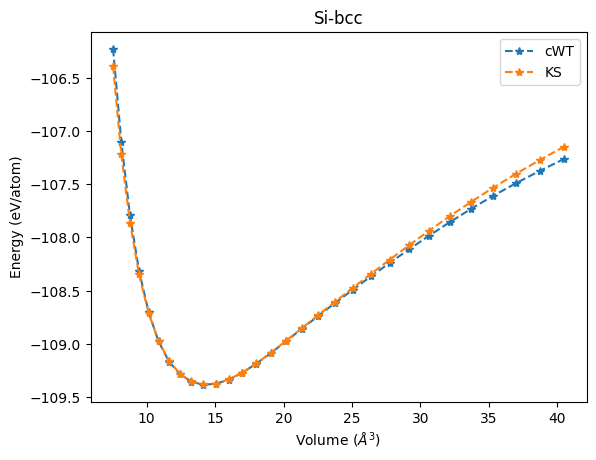

In [11]:
plt.plot(np.asarray(VOLUME)*0.529177**3/2,(np.asarray(ENERGY))*27.211407/2,'*--')
plt.plot(np.asarray(VOLUME)*0.529177**3/2, np.asarray(KS_TE)*27.211407/4,'*--')
plt.xlabel('Volume ($\AA^{3}$)')
plt.ylabel('Energy (eV/atom)')
plt.title('Si-bcc')
plt.legend(['cWT','KS'])
print((np.asarray(KS_TE)*1/2)-(np.asarray(ENERGY)))

In [77]:
l = np.linspace(0.8, 1.4, 30)
rho0 = np.asarray(rho00)
XC = Functional(type='XC',name='LDA')
HARTREE = Functional(type='HARTREE')

VOLUME = []
Forces = []
for n in np.arange(0, 30, 1):
        i = int(n)      
        KE = Functional(type='KEDF',name='WT', rho0=rho0[i])
        ions = Ions.from_ase(bulk('Si', 'bcc', a= 3.09, cubic=True))
        cell = ions.get_cell()
        ions.set_cell(cell * l[i], scale_atoms=True)
        ions.set_charges(4)
        move_atom = ions[1]
        move_atom.position[:] += 0.1
        nr = ecut2nr(ecut=25, lattice=ions.cell)
        grid = DirectGrid(lattice=ions.cell, nr=nr)
        rho_ini = DirectField(grid=grid)
        rho_ini[:] = ions.get_ncharges()/ions.cell.volume
        PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list, rcut=10)
        evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)    
        optimization_options = {'econv' : 1e-5*ions.nat}
        opt = Optimization(EnergyEvaluator=evaluator, optimization_options = optimization_options, 
                           optimization_method = 'TN')
        rho = opt.optimize_rho(guess_rho=rho_ini)
        forces = GetForces(ions, rho, evaluator)
        vol=ions.get_volume()
        VOLUME.append(vol)
        Forces.append(forces)

setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       5.121982952391E+00      5.121983E+00    2.536222E+00    1       1       4.207611E-03    
1       4.666450615973E+00      -4.555323E-01   1.209749E-01    3       1       1.464796E-02    
2       4.652761879589E+00      -1.368874E-02   3.903453E-03    5       1       2.665091E-02    
3       4.652590237149E+00      -1.716424E-04   1.868788E-04    3       1       3.536248E-02    
4       4.652565821612E+00      -2.441554E-05   1.495688E-05    5       1       4.717422E-02    
5       4.652564960850E+00      -8.607622E-07   1.242354E-06    3       1       5.593133E-02    
6       4.652564842127E+00      -1.187222E-07   8.852694E-08    5       1       6.787682E-02    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.8180205812960422
Chemical potential (eV)  : 22.259471689569327
setting key: Si -> /home/vr3

3       2.285854155540E+00      -4.963075E-04   6.441196E-04    4       1       4.450107E-02    
4       2.285785957646E+00      -6.819789E-05   5.250796E-05    6       1       5.985832E-02    
5       2.285783207487E+00      -2.750158E-06   4.850668E-06    3       1       6.926751E-02    
6       2.285782618268E+00      -5.892189E-07   2.610635E-07    5       1       8.257532E-02    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.4299144761005909
Chemical potential (eV)  : 11.698567650382703
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       2.397220644184E+00      2.397221E+00    1.336081E+00    1       1       4.296064E-03    
1       2.082351882748E+00      -3.148688E-01   1.020545E-01    5       1       1.952553E-02    
2       2.067908363579E+00      -1.444352E-02   9.690764E-03    6       1       3.495860E-02    
3       2.067309708546E+00  

setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       1.212375318915E+00      1.212375E+00    1.092594E+00    1       1       5.594730E-03    
1       6.740832496872E-01      -5.382921E-01   1.189096E-01    12      2       4.773140E-02    
2       6.645860526294E-01      -9.497197E-03   1.129065E-02    5       1       6.618142E-02    
3       6.629843157418E-01      -1.601737E-03   7.807768E-04    8       1       9.225488E-02    
4       6.629343280955E-01      -4.998765E-05   7.291757E-05    4       1       1.084995E-01    
5       6.629260938211E-01      -8.234274E-06   4.526116E-06    6       1       1.298153E-01    
6       6.629251906681E-01      -9.031530E-07   3.036573E-07    9       1       1.594031E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.18198320498622192
Chemical potential (eV)  : 4.952014768320228
setting key: Si -> /home/vr3

1       -3.170169995663E-01     -8.645973E-01   4.254058E-01    12      3       6.353855E-02    
2       -3.482619321821E-01     -3.124493E-02   2.515996E-02    4       1       8.343220E-02    
3       -3.498239084835E-01     -1.561976E-03   1.325246E-03    5       1       1.067412E-01    
4       -3.499306366805E-01     -1.067282E-04   8.360585E-05    7       1       1.371176E-01    
5       -3.499397553080E-01     -9.118627E-06   6.267097E-06    8       1       1.711164E-01    
6       -3.499404059587E-01     -6.506508E-07   5.842620E-07    7       1       2.017555E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.051010839536347254
Chemical potential (eV)  : 1.3880755136031921
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       4.866646327088E-01      4.866646E-01    1.008332E+00    1       1       6.858349E-03    
1       -4.283596111445E-0

In [78]:
FORCE = []
FORCE_x = []
FORCE_y = []
FORCE_z = []
for i in np.arange(0,30,1):
    FORCE.append(np.linalg.norm(Forces[i]['TOTAL'][1]))
    FORCE_x.append((Forces[i]['TOTAL'][1,0]))
    FORCE_z.append((Forces[i]['TOTAL'][1,1]))
    FORCE_y.append((Forces[i]['TOTAL'][1,2]))

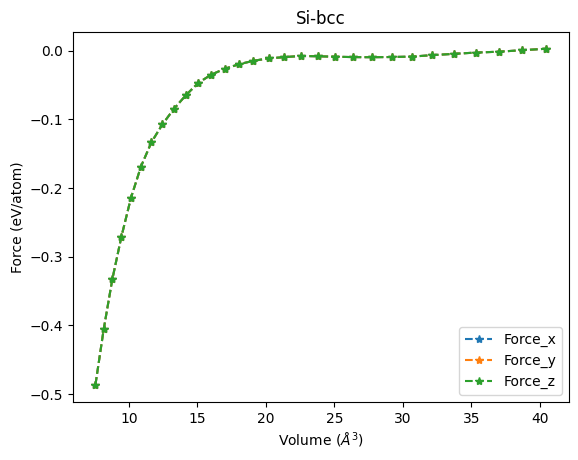

In [79]:
plt.plot(np.asarray(VOLUME)*0.529177**3/2,(np.asarray(FORCE_x))*27.211407/2,'*--')
plt.plot(np.asarray(VOLUME)*0.529177**3/2,(np.asarray(FORCE_y))*27.211407/2,'*--')
plt.plot(np.asarray(VOLUME)*0.529177**3/2,(np.asarray(FORCE_z))*27.211407/2,'*--')

plt.xlabel('Volume ($\AA^{3}$)')
plt.ylabel('Force (eV/atom)')
plt.title('Si-bcc')
plt.legend(['Force_x','Force_y', 'Force_z'])

In [81]:
np.save('/home/vr371/cWT-KEDF/Phases/DATA/Si_bcc/DATA2/Force.npy', Forces)

### Comparing agains Lennerd Jonnes method

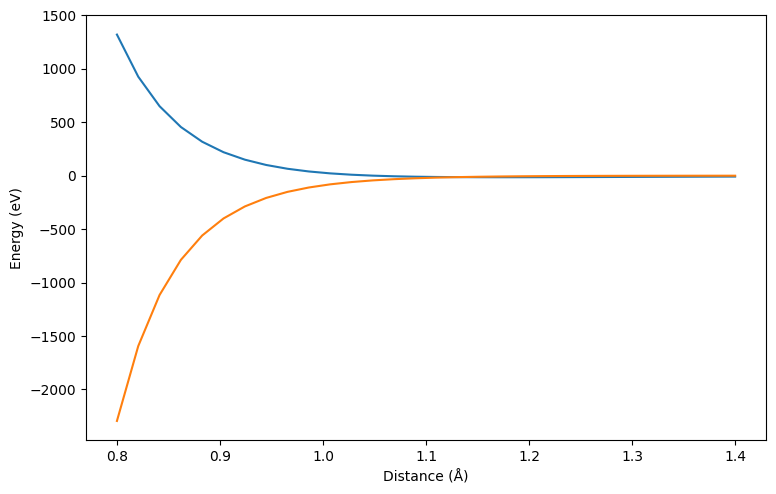

In [76]:
from ase.calculators.lj import LennardJones
from dscribe.descriptors import SOAP

# Setting up the SOAP descriptor
soap = SOAP(
    species=["Si"],
    periodic=True,
    rcut=5.0,
    sigma=0.5,
    nmax=3,
    lmax=0,
)

n_samples = 30
traj = []
n_atoms = 2
energies = np.zeros(n_samples)
forces = np.zeros((n_samples, n_atoms, 3))
r = np.linspace(0.8, 1.4, 30)
for i, d in enumerate(r):
    a = ase.Atoms(bulk('Si', 'bcc', a= 3.09, cubic=True))
    cell = a.get_cell()
    a.set_cell(cell * d, scale_atoms=True)
    move_atom = a[0]
    move_atom.position[0] += 0.2
    a.set_calculator(LennardJones(epsilon=1.0 , sigma=2.9))
    traj.append(a)
    energies[i] = a.get_total_energy()
    forces[i, :, :] = a.get_forces()

# Plot the energies to validate them
fig, ax = plt.subplots(figsize=(8, 5))
plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1)
line, = ax.plot(r, energies)
plt.xlabel("Distance (Å)")
plt.ylabel("Energy (eV)")
order = np.argsort(r)
F_x_whole = forces[:, 0, 0][order]
plt.plot(r,F_x_whole)
